In [1]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

sm.OLS.from_formula

from pmdarima import auto_arima

from pylab import rcParams

In [2]:
#filtro por fecha
def filter_company_data(company_df, start_date, end_date):
    return company_df[(company_df['Date'] >= start_date) & (company_df['Date'] <= end_date)]

# Funcion para convertir signo dolar a numerico
def convert_dollars_to_numerical(value):
    if isinstance(value, str) and re.match(r'\$\d+', value):
        return float(value.replace('$', ''))
    return value

# funcion para calcular el RMSE
def RMSE(predicted, actual):
    mse = (predicted - actual) ** 2
    rmse = np.sqrt(mse.sum() / mse.count())
    return rmse

# función para predicción random walk
def random_walk_pred (df, target_column, test_size):
        
    data = df.copy()
    
    #separa en train y test
    data_train, data_test = train_test_split(data, test_size=test_size, random_state=2024, shuffle=False)
    
    #genero desplazo en train
    data_train["PriceShift1"] = data_train[target_column].shift()
    data_train["PriceShift1"].fillna(method='bfill', inplace=True)
    
    #genero desplazo en test
    data_test["PriceShift1"] = data_test[target_column].shift()
    data_test["PriceShift1"].fillna(method='bfill', inplace=True)
    
    data_train["RandomWalk"] = data_train.PriceShift1    
    data_test["RandomWalk"] = pd.Series(data_train[target_column].iloc[-1], index=data_test.index)
    
    data_combined = pd.concat([data_train, data_test])
    fig, ax = plt.subplots(figsize=(10,5))
    data_combined.plot(kind='line', y=[target_column,"RandomWalk"], ax=ax)
    ax.axvline(data_train.index[-1], color='r', linestyle='--', lw=2)  # línea para separar el entrenamiento y la prueba
    plt.title('Train and Test - Random Walk Prediction')
    plt.show()
    
    index = df_Results.shape[0]
    df_Results.loc[index, "Model"] = "Random Walk"
    df_Results.loc[index, "RMSE"] = RMSE(data_test.RandomWalk, data_test[target_column])
    df_Results
    
    print(df_Results.head())
    
    return

# defino funcion predictiva con la media
def mean_pred(df, target_column, test_size):
    
    data = df.copy()
    
    #separa en train y test
    data_train, data_test = train_test_split(data, test_size=test_size, random_state=2024, shuffle=False)

    model_mean_pred = data_train[target_column].mean()
    print('Mean: ', model_mean_pred)
    
    #df_train_mc = data train.copy()
    data_train['Mean'] = model_mean_pred
    
    #df_test_mc = data_train.copy()
    data_test['Mean'] = model_mean_pred
    
    data_combined = pd.concat([data_train, data_test])
    fig, ax = plt.subplots(figsize=(10,5))
    data_combined.plot(kind='line', y=[target_column,"Mean"], ax=ax)
    ax.axvline(data_train.index[-1], color='r', linestyle='--', lw=2)  # línea para separar el entrenamiento y la prueba
    plt.title('Train and Test - Mean Prediction')
    plt.show()
    
    model_RMSE = RMSE(data_test.Mean, data_test[target_column])
    index = df_Results.shape[0]
    df_Results.loc[index, "Model"] = "Mean"
    df_Results.loc[index, "RMSE"] = model_RMSE
    print(df_Results.head())
    
    return

# defino una funcion para predecir con la tendencia lineal
def lineal_pred(df, target_column,test_size):
    
    data = df.copy()
    
    data["timeIndex"] = pd.Series(np.arange(len(data[target_column])), index=data.index)
    data.timeIndex.head(3)
    
    data_train, data_test = train_test_split(data, test_size=test_size, random_state=2024, shuffle=False)
    
    formula = f'{target_column} ~ timeIndex'
    model_linear = smf.ols(formula=formula, data = data_train).fit()
    
    data_train["LinearTrend"] = model_linear.predict(data_train.timeIndex)
    data_test["LinearTrend"] = model_linear.predict(data_test.timeIndex)
    
    data_combined = pd.concat([data_train, data_test])
    fig, ax = plt.subplots(figsize=(10,5))
    data_combined.plot(kind='line', y=[target_column,"LinearTrend"], ax=ax)
    ax.axvline(data_train.index[-1], color='r', linestyle='--', lw=2)  # línea para separar el entrenamiento y la prueba
    plt.title('Train and Test - Lineal Prediction')
    plt.show()
    
    model_RMSE = RMSE(data_test.LinearTrend, data_test[target_column])
    index = df_Results.shape[0]
    df_Results.loc[index, "Model"] = "LinearTrend"
    df_Results.loc[index, "RMSE"] = model_RMSE
    print(df_Results.head())
    print( )
    print(model_linear.summary())
    
    return

#defino una funcion para predecicción exponencial
def exp_pred(df, target_column, test_size, exp=2):
   
    data = df.copy()
    
    data["timeIndex"] = pd.Series(np.arange(len(data[target_column])), index=data.index)
    data["timeIndex_exp"] = data["timeIndex"]**exp
    data.timeIndex_exp.head(3)
    
    data_train, data_test = train_test_split(data, test_size = test_size, random_state=2024, shuffle=False)
    
    formula = f'{target_column} ~ timeIndex + timeIndex_exp'
    model_exp = smf.ols(formula = formula, data = data_train).fit()

    data_train["ExpTrend"] = model_exp.predict(data_train[["timeIndex","timeIndex_exp"]])
    data_test["ExpTrend"] = model_exp.predict(data_test[["timeIndex","timeIndex_exp"]])
    
    data_combined = pd.concat([data_train, data_test])
    fig, ax = plt.subplots(figsize=(10,5))
    data_combined.plot(kind='line', y=[target_column,"ExpTrend"], ax=ax)
    ax.axvline(data_train.index[-1], color='r', linestyle='--', lw=2)  # línea para separar el entrenamiento y la prueba
    plt.title('Train and Test - Exponencial Prediction')
    plt.show()
    
    model_RMSE = RMSE(data_test.ExpTrend, data_test[target_column])
    index = df_Results.shape[0]
    df_Results.loc[index, "Model"] = "ExpTrend"
    df_Results.loc[index, "RMSE"] = model_RMSE
    print(df_Results.head())
    print( )
    print(model_exp.summary())
    
    return

# defino una función para hacer predección logaritmica
def log_pred(df, target_column, test_size):
    
    data = df.copy()
    
    data["timeIndex"] = pd.Series(np.arange(len(data[target_column])), index=data.index)

    data_train, data_test = train_test_split(data, test_size = test_size, random_state=2024, shuffle=False)
    
    data_train['log_target'] = np.log(data_train[target_column])
    data_test['log_target'] = np.log(data_test[target_column])
    
    model_log = smf.ols('log_target ~ timeIndex ', data = data_train).fit()
    
    data_train["LogTrend"] = model_log.predict(data_train[["timeIndex"]])
    data_test["LogTrend"] = model_log.predict(data_test[["timeIndex"]])
    
    data_train['back_LogTrend'] = np.exp(data_train['LogTrend'])
    data_test['back_LogTrend'] = np.exp(data_test['LogTrend'])
    
    data_combined = pd.concat([data_train, data_test])
    fig, ax = plt.subplots(figsize=(10,5))
    data_combined.plot(kind='line', y=[target_column,"back_LogTrend"], ax=ax)
    ax.axvline(data_train.index[-1], color='r', linestyle='--', lw=2)  # línea para separar el entrenamiento y la prueba
    plt.title('Train and Test - Logaritmical Prediction')
    plt.show()
    
    model_RMSE = RMSE(data_test.back_LogTrend, data_test[target_column])
    index = df_Results.shape[0]
    df_Results.loc[index, "Model"] = "back_LogTrend"
    df_Results.loc[index, "RMSE"] = model_RMSE
    print(df_Results.head())
    print( )
    print(model_log.summary())
    
    return    

In [3]:
df_do = pd.read_csv('./datasets/DJIA_5year.csv', sep=',')
df_dow = df_do.drop(df_do.index[:8])

df_dow.reset_index(drop=True, inplace=True)

df_dow

,Date,Close/Last,Volume,Open,High,Low
0,05/10/2024,39512.84,NaN,39466.52,39579.88,39406.26
1,05/09/2024,39387.76,NaN,39064.27,39413.66,38988.85
2,05/08/2024,39056.39,NaN,38818.90,39094.74,38814.99
3,05/07/2024,38884.26,NaN,38858.94,38977.61,38840.40
4,05/06/2024,38852.27,NaN,38762.43,38886.47,38689.38
...,...,...,...,...,...,...
1247,05/29/2019,25126.41,NaN,25231.46,25231.46,24938.24
1248,05/28/2019,25347.77,NaN,25616.55,25717.63,25342.28
1249,05/24/2019,25585.69,NaN,25551.07,25670.81,25496.20
1250,05/23/2019,25490.47,NaN,25657.99,25657.99,25328.09


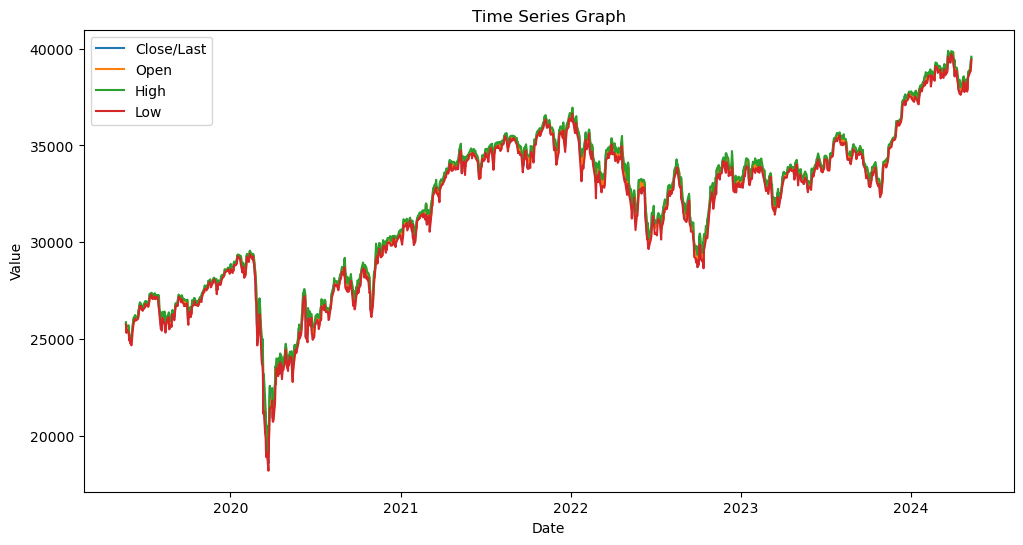

In [4]:
# Plot ilustrativo sobre los valores 'Close/Last', 'Open', 'High' and 'Low'. 

# Sorto las fechas
df_dow = df_dow.sort_values(by = "Date")
df_dow['Date'] = pd.to_datetime(df_dow['Date'])

# Convertir 'Date' a dummy de tiempo
df_dow['Time_index'] = pd.Series(np.arange(len(df_dow['Date'])), index=df_dow.index) 

plt.figure(figsize=(12, 6))
sns.lineplot(x='Date', y='Close/Last', data=df_dow, label='Close/Last')
sns.lineplot(x='Date', y='Open', data=df_dow, label='Open')
sns.lineplot(x='Date', y='High', data=df_dow, label='High')
sns.lineplot(x='Date', y='Low', data=df_dow, label='Low')


plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Time Series Graph')
plt.legend(loc='upper left')

plt.show()


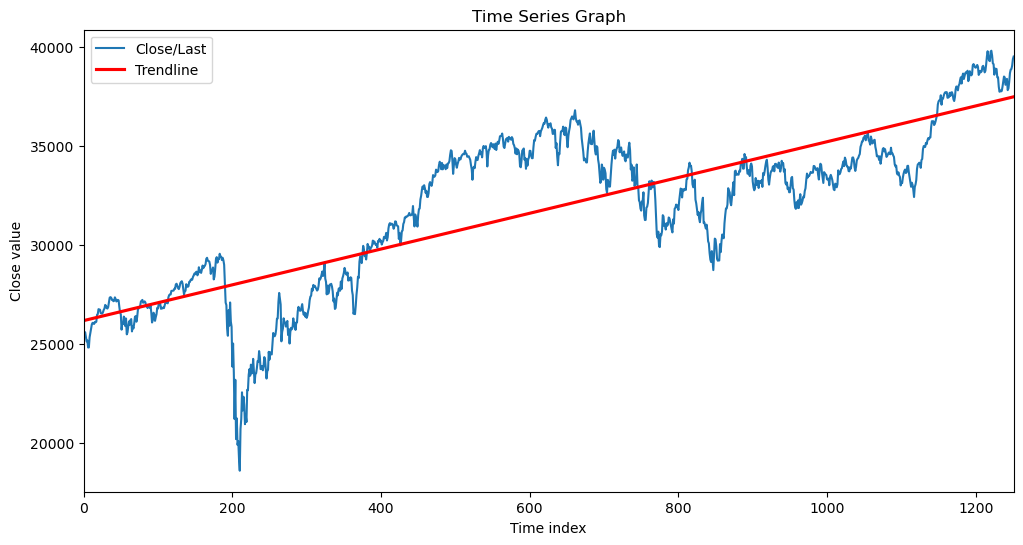

In [5]:
# Plot del valor 'Close/Last' y linea de regresion

# Sorto las fechas
df_dow = df_dow.sort_values(by = "Date")
df_dow['Date'] = pd.to_datetime(df_dow['Date'])

# Convertir 'Date' a dummy de tiempo
df_dow['Time_index'] = pd.Series(np.arange(len(df_dow['Date'])), index=df_dow.index) 

plt.figure(figsize=(12, 6))
sns.lineplot(x='Time_index', y='Close/Last', data=df_dow, label='Close/Last')
sns.regplot(x='Time_index', y='Close/Last', data=df_dow, scatter=False, label='Trendline', ci=None, color='red')


plt.xlabel('Time index')
plt.ylabel('Close value')
plt.title('Time Series Graph')
plt.legend(loc='upper left')

plt.show()

In [6]:
#defino lso nobmres de los csv a utilizar
company_dates = {
"Procter":("2019-05-13", "2024-05-10"),
"3M": ("2019-05-13", "2024-05-10"),
"Merck": ("2019-05-13", "2024-05-10"),
"IBM": ("2019-05-13", "2024-05-10"),
"Amex": ("2019-05-13", "2024-05-10"),
"McDonalds": ("2019-05-13","2024-05-10"),
"Coca": ("2019-05-13", "2024-05-10"),
"Boeing": ("2019-05-13","2024-05-10"),
"JPMorgan": ("2019-05-13", "2024-05-10"),
"Dow": ("2019-05-13","2024-05-10"),
"Disney": ("2019-05-13", "2024-05-10"),
"Caterpillar": ("2019-05-13", "2024-05-10"),
"Walmart": ("2019-05-13","2024-05-10"),
"JNJ": ("2019-05-13", "2024-05-10"),
"Microsoft": ("2019-05-13","2024-05-10"),
"Intel": ("2019-05-13", "2024-05-10"),
"HomeDepot": ("2019-05-13","2024-05-10"),
"Verizon": ("2019-05-13", "2024-05-10"),
"Chevron": ("2019-05-13","2024-05-10"),
"Travelers": ("2019-05-13", "2024-05-10"),
"Cisco": ("2019-05-13","2024-05-10"),
"UnitedHealth": ("2019-05-13", "2024-05-10"),
"Visa": ("2019-05-13","2024-05-10"),
"Nike": ("2019-05-13", "2024-05-10"),
"Apple": ("2019-05-13", "2024-05-10"),
"Goldman": ("2019-04-02","2024-05-10"),
"Salesforce": ("2020-08-31","2024-05-10"),
"Honeywell": ("2020-08-31","2024-05-10"),
"Amgen": ("2020-08-31","2024-05-10"),
"Amazon": ("2024-02-26","2024-05-10"),
"Exxon":("2019-05-13", "2020-08-30"),
"Pfizer": ("2019-05-13","2020-08-30"),
"Raytheon":("2019-05-13", "2020-08-30"),
"Walgreens":("2018-06-26", "2024-02-25"),
}


In [7]:
# Creo nuevo df para mergear 
df_merge = df_dow.copy()

In [8]:
for company, (start_date, end_date) in company_dates.items():
    # cargo dataset de la compañia
    company_df = pd.read_csv(f'./datasets/companies/{company}.csv')
    company_df = company_df.applymap(convert_dollars_to_numerical)
    # Convierto a fecha  la columna date
    company_df['Date'] = pd.to_datetime(company_df['Date'])
    
    # obtengo 
    if company in company_dates:
        start_date, end_date = company_dates[company]
        
        # Filtro por fechas
        filtered_company_df = filter_company_data(company_df, start_date, end_date)
        
        # Mergeo con mi dataset 
        df_merge = pd.merge(df_merge, filtered_company_df, on='Date', how='left', suffixes=('', f'_{company}'))

# Save the merged dataset
df_merge.to_csv('./datasets/merged_dow_jones.csv', index=False)

In [9]:
pd.set_option('display.max_columns', None) 
df_merge.head()

,Date,Close/Last,Volume,Open,High,Low,Time_index,Close/Last_Procter,Volume_Procter,Open_Procter,High_Procter,Low_Procter,Close/Last_3M,Volume_3M,Open_3M,High_3M,Low_3M,Close/Last_Merck,Volume_Merck,Open_Merck,High_Merck,Low_Merck,Close/Last_IBM,Volume_IBM,Open_IBM,High_IBM,Low_IBM,Close/Last_Amex,Volume_Amex,Open_Amex,High_Amex,Low_Amex,Close/Last_McDonalds,Volume_McDonalds,Open_McDonalds,High_McDonalds,Low_McDonalds,Close/Last_Coca,Volume_Coca,Open_Coca,High_Coca,Low_Coca,Close/Last_Boeing,Volume_Boeing,Open_Boeing,High_Boeing,Low_Boeing,Close/Last_JPMorgan,Volume_JPMorgan,Open_JPMorgan,High_JPMorgan,Low_JPMorgan,Close/Last_Dow,Volume_Dow,Open_Dow,High_Dow,Low_Dow,Close/Last_Disney,Volume_Disney,Open_Disney,High_Disney,Low_Disney,Close/Last_Caterpillar,Volume_Caterpillar,Open_Caterpillar,High_Caterpillar,Low_Caterpillar,Close/Last_Walmart,Volume_Walmart,Open_Walmart,High_Walmart,Low_Walmart,Close/Last_JNJ,Volume_JNJ,Open_JNJ,High_JNJ,Low_JNJ,Close/Last_Microsoft,Volume_Microsoft,Open_Microsoft,High_Microsoft,Low_Microsoft,Close/Last_Intel,Volume_Intel,Open_Intel,High_Intel,Low_Intel,Close/Last_HomeDepot,Volume_HomeDepot,Open_HomeDepot,High_HomeDepot,Low_HomeDepot,Close/Last_Verizon,Volume_Verizon,Open_Verizon,High_Verizon,Low_Verizon,Close/Last_Chevron,Volume_Chevron,Open_Chevron,High_Chevron,Low_Chevron,Close/Last_Travelers,Volume_Travelers,Open_Travelers,High_Travelers,Low_Travelers,Close/Last_Cisco,Volume_Cisco,Open_Cisco,High_Cisco,Low_Cisco,Close/Last_UnitedHealth,Volume_UnitedHealth,Open_UnitedHealth,High_UnitedHealth,Low_UnitedHealth,Close/Last_Visa,Volume_Visa,Open_Visa,High_Visa,Low_Visa,Close/Last_Nike,Volume_Nike,Open_Nike,High_Nike,Low_Nike,Close/Last_Apple,Volume_Apple,Open_Apple,High_Apple,Low_Apple,Close/Last_Goldman,Volume_Goldman,Open_Goldman,High_Goldman,Low_Goldman,Close/Last_Salesforce,Volume_Salesforce,Open_Salesforce,High_Salesforce,Low_Salesforce,Close/Last_Honeywell,Volume_Honeywell,Open_Honeywell,High_Honeywell,Low_Honeywell,Close/Last_Amgen,Volume_Amgen,Open_Amgen,High_Amgen,Low_Amgen,Close/Last_Amazon,Volume_Amazon,Open_Amazon,High_Amazon,Low_Amazon,Close/Last_Exxon,Volume_Exxon,Open_Exxon,High_Exxon,Low_Exxon,Close/Last_Pfizer,Volume_Pfizer,Open_Pfizer,High_Pfizer,Low_Pfizer,Close/Last_Raytheon,Volume_Raytheon,Open_Raytheon,High_Raytheon,Low_Raytheon,Close/Last_Walgreens,Volume_Walgreens,Open_Walgreens,High_Walgreens,Low_Walgreens
0,2019-05-22,25776.61,NaN,25818.46,25878.21,25755.11,0,106.72,4889697,106.09,107.050,105.940,145.7040,4504159,143.7211,146.5796,142.8885,78.1515,12873870,76.5784,78.3156,76.5398,131.9741,1849821,131.6353,132.3613,131.3562,120.01,2941084,120.36,120.88,119.4400,199.96,1760440,199.52,200.17,198.50,49.65,16050700,48.78,49.71,48.7200,352.78,3841430,357.22,357.57,351.75,110.82,7918898,111.40,111.79,110.75,50.21,3019120,50.46,50.610,49.965,133.85,5093746,133.82,134.17,133.3900,123.56,4620431,124.25,125.4393,123.52,34.0767,22022627,33.8667,34.1433,33.6867,138.76,5456839,138.35,138.95,137.485,127.67,15396490,126.62,128.240,126.52,44.00,16932520,44.15,44.46,43.8450,188.91,5706339,190.49,192.22,188.05,59.25,11487450,59.09,59.3700,58.96,120.57,5763543,120.90,121.435,120.340,147.96,1104158,147.48,148.2616,146.94,55.69,19479170,56.22,56.30,55.670,249.34,4038028,249.10,251.0300,248.71,164.24,5416382,163.60,165.63,163.45,83.20,5237761,82.99,83.34,82.76,45.6950,118994240,46.165,46.4275,45.6375,195.52,2427247,197.44,198.48,195.46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75.56,7858317.0,76.02,76.22,75.385,41.0440,23979960.0,40.7508,41.2591,40.6139,80.2919,1942732.0,80.2623,80.8315,80.0133,52.94,3372200.0,52.77,53.01,52.390
1,2019-05-23,25490.47,NaN,25657.99,25657.99,25328.09,1,106.76,6175566,106.68,107.030,105.885,142.3820,3830288,143.8499,144.4679,141.2833,78.1901,9381160,77.7848,78.3542,77.6014,128.1412,5343437,130.7933,130.7933,126.2538,118.43,3290185,119.27,119.40,117.8500,198.97,3560545,198.81,199.43,198.10,49.85,12199510,49.50,49.90,49.4601,350.5

In [10]:
# Filtro los datos para crear un nuevo dataframe con los valores de "Date" y "Close/Last"

df_columns = df_merge.columns.values.tolist()

regex = 'Close'
date = 'Date'
list_close_last = [ x for x in df_columns if re.search(regex, x) or re.search(date, x)]

print(list_close_last)

df_close_last = df_merge[list_close_last]


['Date', 'Close/Last', 'Close/Last_Procter', 'Close/Last_3M', 'Close/Last_Merck', 'Close/Last_IBM', 'Close/Last_Amex', 'Close/Last_McDonalds', 'Close/Last_Coca', 'Close/Last_Boeing', 'Close/Last_JPMorgan', 'Close/Last_Dow', 'Close/Last_Disney', 'Close/Last_Caterpillar', 'Close/Last_Walmart', 'Close/Last_JNJ', 'Close/Last_Microsoft', 'Close/Last_Intel', 'Close/Last_HomeDepot', 'Close/Last_Verizon', 'Close/Last_Chevron', 'Close/Last_Travelers', 'Close/Last_Cisco', 'Close/Last_UnitedHealth', 'Close/Last_Visa', 'Close/Last_Nike', 'Close/Last_Apple', 'Close/Last_Goldman', 'Close/Last_Salesforce', 'Close/Last_Honeywell', 'Close/Last_Amgen', 'Close/Last_Amazon', 'Close/Last_Exxon', 'Close/Last_Pfizer', 'Close/Last_Raytheon', 'Close/Last_Walgreens']


In [11]:
df_close_last.head(3)

,Date,Close/Last,Close/Last_Procter,Close/Last_3M,Close/Last_Merck,Close/Last_IBM,Close/Last_Amex,Close/Last_McDonalds,Close/Last_Coca,Close/Last_Boeing,Close/Last_JPMorgan,Close/Last_Dow,Close/Last_Disney,Close/Last_Caterpillar,Close/Last_Walmart,Close/Last_JNJ,Close/Last_Microsoft,Close/Last_Intel,Close/Last_HomeDepot,Close/Last_Verizon,Close/Last_Chevron,Close/Last_Travelers,Close/Last_Cisco,Close/Last_UnitedHealth,Close/Last_Visa,Close/Last_Nike,Close/Last_Apple,Close/Last_Goldman,Close/Last_Salesforce,Close/Last_Honeywell,Close/Last_Amgen,Close/Last_Amazon,Close/Last_Exxon,Close/Last_Pfizer,Close/Last_Raytheon,Close/Last_Walgreens
0,2019-05-22,25776.61,106.72,145.7040,78.1515,131.9741,120.01,199.96,49.65,352.78,110.82,50.21,133.85,123.56,34.0767,138.76,127.67,44.00,188.91,59.25,120.57,147.96,55.69,249.34,164.24,83.20,45.6950,195.52,NaN,NaN,NaN,NaN,75.56,41.0440,80.2919,52.94
1,2019-05-23,25490.47,106.76,142.3820,78.1901,128.1412,118.43,198.97,49.85,350.55,108.64,48.71,132.73,122.26,33.9533,139.79,126.18,44.53,192.00,58.87,117.87,146.94,54.19,246.50,161.51,82.64,44.9150,191.97,NaN,NaN,NaN,NaN,73.79,40.9756,77.3509,51.61
2,2019-05-24,25585.69,106.69,142.5709,78.3349,128.0347,119.51,197.77,49.61,354.90,109.71,49.20,132.79,122.90,34.2233,138.85,126.24,44.57,193.59,59.32,118.71,147.94,54.37,247.63,162.64,82.16,44.7425,193.00,NaN,NaN,NaN,NaN,74.10,41.0049,77.9142,51.77


In [12]:
# Renombrar columnas para mayor claridad
rename_function = lambda name: 'Index' if name == 'Close/Last' else name.split('_')[-1]

# Funcion para renombrar
new_column_names = list(map(rename_function, list_close_last))

df_close_last.rename(columns=dict(zip(df_close_last.columns, new_column_names)), inplace=True)

df_close_last.head()

/home/gabriel/anaconda3/envs/dhdsblend2021/lib/python3.8/site-packages/pandas/core/frame.py:4300: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,Date,Index,Procter,3M,Merck,IBM,Amex,McDonalds,Coca,Boeing,JPMorgan,Dow,Disney,Caterpillar,Walmart,JNJ,Microsoft,Intel,HomeDepot,Verizon,Chevron,Travelers,Cisco,UnitedHealth,Visa,Nike,Apple,Goldman,Salesforce,Honeywell,Amgen,Amazon,Exxon,Pfizer,Raytheon,Walgreens
0,2019-05-22,25776.61,106.72,145.7040,78.1515,131.9741,120.01,199.96,49.65,352.78,110.82,50.21,133.85,123.56,34.0767,138.76,127.67,44.00,188.91,59.25,120.57,147.96,55.69,249.34,164.24,83.20,45.6950,195.52,NaN,NaN,NaN,NaN,75.56,41.0440,80.2919,52.94
1,2019-05-23,25490.47,106.76,142.3820,78.1901,128.1412,118.43,198.97,49.85,350.55,108.64,48.71,132.73,122.26,33.9533,139.79,126.18,44.53,192.00,58.87,117.87,146.94,54.19,246.50,161.51,82.64,44.9150,191.97,NaN,NaN,NaN,NaN,73.79,40.9756,77.3509,51.61
2,2019-05-24,25585.69,106.69,142.5709,78.3349,128.0347,119.51,197.77,49.61,354.90,109.71,49.20,132.79,122.90,34.2233,138.85,126.24,44.57,193.59,59.32,118.71,147.94,54.37,247.63,162.64,82.16,44.7425,193.00,NaN,NaN,NaN,NaN,74.10,41.0049,77.9142,51.77
3,2019-05-28,25347.77,104.46,140.2189,77.4567,126.2731,118.17,196.67,49.10,354.88,108.52,48.56,132.62,121.59,34.1400,137.07,126.16,43.57,191.55,58.73,118.31,146.28,53.93,242.06,163.71,81.20,44.5575,189.44,NaN,NaN,NaN,NaN,72.61,40.9560,77.0366,51.69
4,2019-05-29,25126.41,104.19,138.5450,76.5881,125.5278,117.01,196.02,48.61,348.80,108.22,48.71,131.57,121.48,34.0400,131.33,124.94,44.23,189.99,58.18,116.77,145.07,53.18,242.40,162.73,78.87,44.3450,188.05,NaN,NaN,NaN,NaN,72.16,40.7801,76.7698,51.13


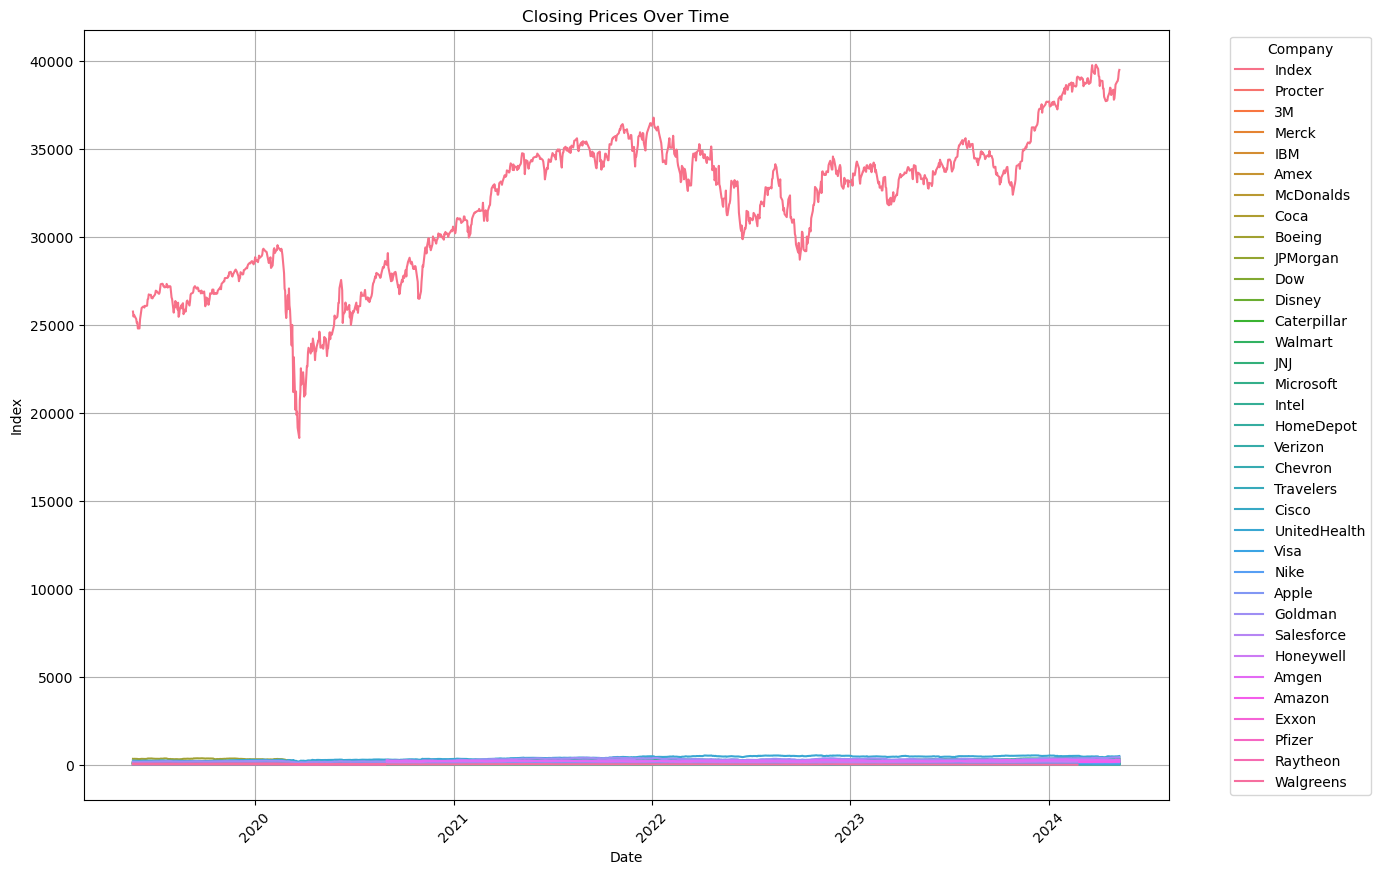

In [13]:
# Plot de los valores para cada empresa

melted_df = df_close_last.melt(id_vars=['Date'], var_name='Company', value_name='Close_value')

plt.figure(figsize=(14, 10))
sns.lineplot(data=melted_df, x='Date', y='Close_value', hue='Company')

plt.title('Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Index')
plt.legend(title='Company', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [14]:
# Correlaciones:

# Matriz de correlacion
correlation_matrix = df_close_last.corr()
print(correlation_matrix)


                 Index   Procter        3M     Merck       IBM      Amex  \
Index         1.000000  0.858189 -0.287993  0.575234  0.654582  0.925775   
Procter       0.858189  1.000000 -0.418161  0.585394  0.480363  0.771185   
3M           -0.287993 -0.418161  1.000000 -0.838995 -0.426092 -0.350114   
Merck         0.575234  0.585394 -0.838995  1.000000  0.700565  0.617275   
IBM           0.654582  0.480363 -0.426092  0.700565  1.000000  0.714595   
Amex          0.925775  0.771185 -0.350114  0.617275  0.714595  1.000000   
McDonalds     0.846866  0.831303 -0.630025  0.787436  0.597773  0.797418   
Coca          0.692758  0.733965 -0.456820  0.623064  0.496785  0.742283   
Boeing       -0.209440 -0.430104  0.337648 -0.168961  0.100821 -0.128645   
JPMorgan      0.889740  0.632772 -0.123405  0.471687  0.692082  0.861999   
Dow           0.710836  0.534186  0.242192  0.091238  0.309714  0.658027   
Disney       -0.002089 -0.228755  0.887396 -0.667067 -0.235276 -0.064350   
Caterpillar 

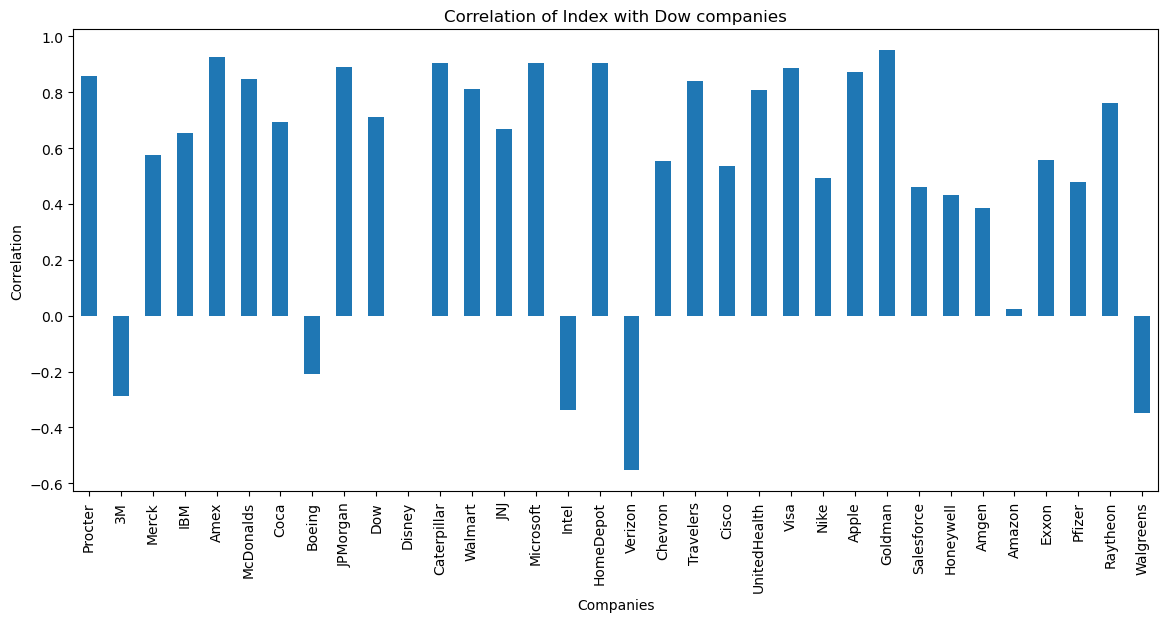

In [15]:
# Correlacion de las empresas con el Dow Index
# Son demasiadas empresas, por lo tanto las correlaciones se muestran mejor como grafico de histogramas
# Transposicion de la matriz
correlation_matrix = correlation_matrix[['Index']].transpose()

# Todas las correlaciones a partir de la segunda columna
correlations = correlation_matrix.loc['Index', 'Procter':]

# Plot 
plt.figure(figsize=(14, 6))
correlations.plot(kind='bar')
plt.xlabel('Companies')
plt.ylabel('Correlation')
plt.title('Correlation of Index with Dow companies')
plt.xticks(rotation=90, fontsize=10)
plt.show()

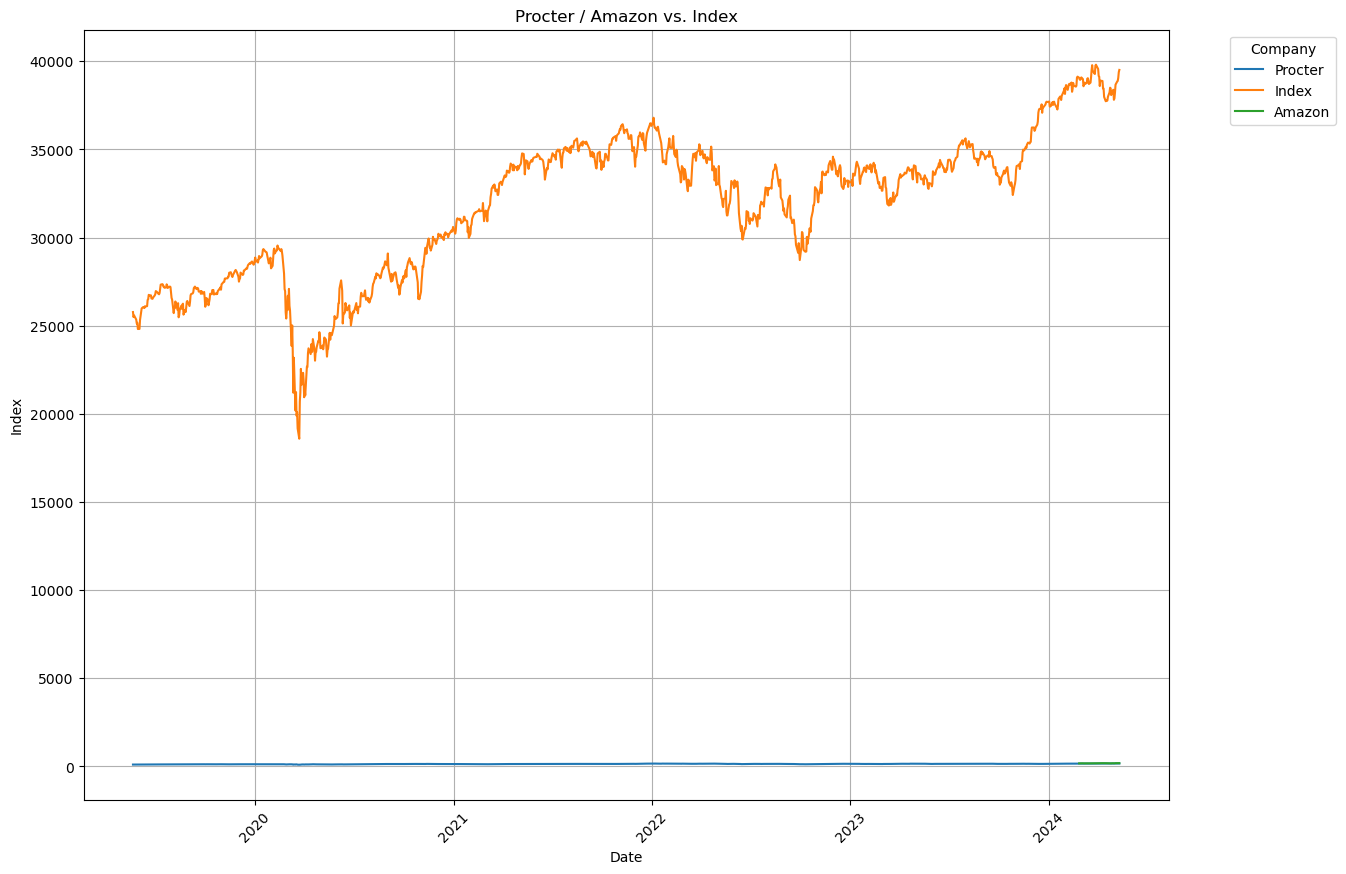

In [16]:
# Porque la correlacion de Amazon es tan baja respecto al Index? 
# Porque se sumó hace muy poco tiempo. 
# Ver la comparacion con Procter (la mas antigua)

plt.figure(figsize=(14, 10))
sns.lineplot(x='Date', y='Procter', data=df_close_last, label='Procter')
sns.lineplot(x='Date', y='Index', data=df_close_last, label='Index')
sns.lineplot(x='Date', y='Amazon', data=df_close_last, label='Amazon')

plt.title('Procter / Amazon vs. Index')
plt.xlabel('Date')
plt.ylabel('Index')
plt.legend(title='Company', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [17]:
df_close_last.head(2)

,Date,Index,Procter,3M,Merck,IBM,Amex,McDonalds,Coca,Boeing,JPMorgan,Dow,Disney,Caterpillar,Walmart,JNJ,Microsoft,Intel,HomeDepot,Verizon,Chevron,Travelers,Cisco,UnitedHealth,Visa,Nike,Apple,Goldman,Salesforce,Honeywell,Amgen,Amazon,Exxon,Pfizer,Raytheon,Walgreens
0,2019-05-22,25776.61,106.72,145.704,78.1515,131.9741,120.01,199.96,49.65,352.78,110.82,50.21,133.85,123.56,34.0767,138.76,127.67,44.00,188.91,59.25,120.57,147.96,55.69,249.34,164.24,83.20,45.695,195.52,NaN,NaN,NaN,NaN,75.56,41.0440,80.2919,52.94
1,2019-05-23,25490.47,106.76,142.382,78.1901,128.1412,118.43,198.97,49.85,350.55,108.64,48.71,132.73,122.26,33.9533,139.79,126.18,44.53,192.00,58.87,117.87,146.94,54.19,246.50,161.51,82.64,44.915,191.97,NaN,NaN,NaN,NaN,73.79,40.9756,77.3509,51.61


In [18]:
#creo un df de resultados de las primeras predicciones
df_Results = pd.DataFrame(columns = ["Model", "RMSE"])

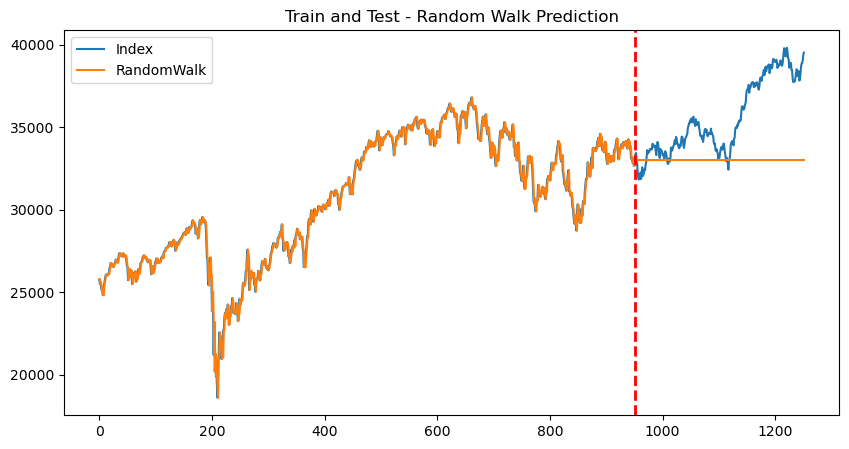

         Model     RMSE
0  Random Walk  3382.57


In [19]:
random_walk_pred(df_close_last,'Index', 300)

Mean:  30662.55807773109


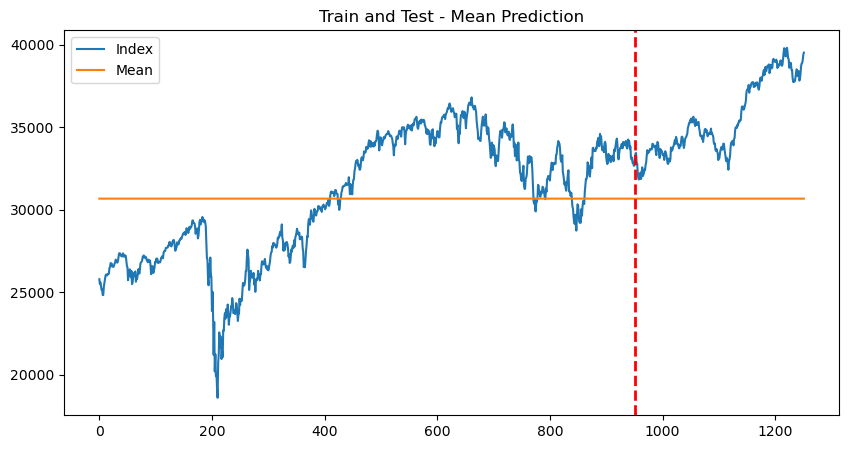

         Model     RMSE
0  Random Walk  3382.57
1         Mean  5358.65


In [20]:
mean_pred(df_close_last,'Index', 300)

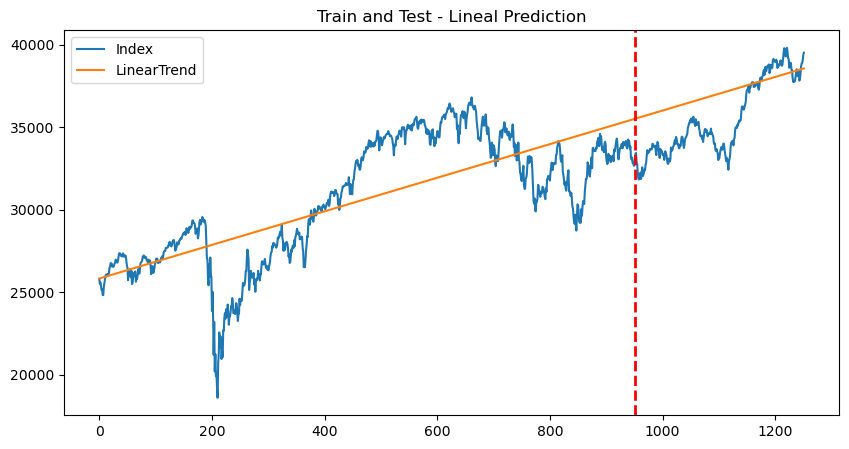

         Model     RMSE
0  Random Walk  3382.57
1         Mean  5358.65
2  LinearTrend  2151.64

                            OLS Regression Results                            
Dep. Variable:                  Index   R-squared:                       0.555
Model:                            OLS   Adj. R-squared:                  0.554
Method:                 Least Squares   F-statistic:                     1184.
Date:                Thu, 23 May 2024   Prob (F-statistic):          3.76e-169
Time:                        18:58:14   Log-Likelihood:                -8801.4
No. Observations:                 952   AIC:                         1.761e+04
Df Residuals:                     950   BIC:                         1.762e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

In [21]:
lineal_pred(df_close_last,'Index', 300)

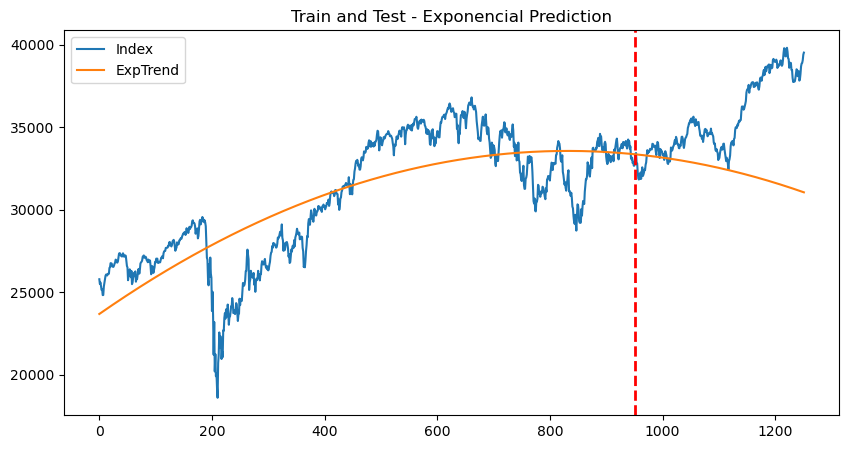

         Model     RMSE
0  Random Walk  3382.57
1         Mean  5358.65
2  LinearTrend  2151.64
3     ExpTrend  4241.91

                            OLS Regression Results                            
Dep. Variable:                  Index   R-squared:                       0.621
Model:                            OLS   Adj. R-squared:                  0.620
Method:                 Least Squares   F-statistic:                     777.0
Date:                Thu, 23 May 2024   Prob (F-statistic):          1.38e-200
Time:                        18:58:15   Log-Likelihood:                -8725.0
No. Observations:                 952   AIC:                         1.746e+04
Df Residuals:                     949   BIC:                         1.747e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
-------

In [22]:
exp_pred(df_close_last,'Index', 300)

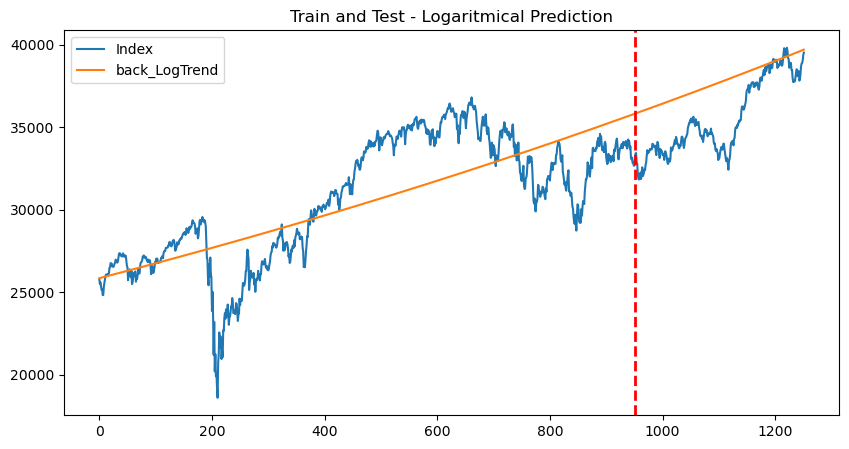

           Model     RMSE
0    Random Walk  3382.57
1           Mean  5358.65
2    LinearTrend  2151.64
3       ExpTrend  4241.91
4  back_LogTrend  2590.44

                            OLS Regression Results                            
Dep. Variable:             log_target   R-squared:                       0.548
Model:                            OLS   Adj. R-squared:                  0.547
Method:                 Least Squares   F-statistic:                     1150.
Date:                Thu, 23 May 2024   Prob (F-statistic):          8.74e-166
Time:                        18:58:15   Log-Likelihood:                 988.01
No. Observations:                 952   AIC:                            -1972.
Df Residuals:                     950   BIC:                            -1962.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t

In [23]:
log_pred(df_close_last,'Index', 300)

['Procter', '3M', 'Merck', 'IBM', 'Amex', 'McDonalds', 'Coca', 'Boeing', 'JPMorgan', 'Dow', 'Disney', 'Caterpillar', 'Walmart', 'JNJ', 'Microsoft', 'Intel', 'HomeDepot', 'Verizon', 'Chevron', 'Travelers', 'Cisco', 'UnitedHealth', 'Visa', 'Nike', 'Apple', 'Goldman', 'Salesforce', 'Honeywell', 'Amgen', 'Amazon', 'Exxon', 'Pfizer', 'Raytheon', 'Walgreens']
Explained variance by component: [0.44934296 0.17593234 0.10740557 0.07351516 0.0329218 ]
          Index           PC1           PC2           PC3           PC4  \
Index  1.000000 -9.278568e-01 -3.601536e-01  4.121191e-02  3.639797e-02   
PC1   -0.927857  1.000000e+00 -7.864273e-17  2.813194e-16  1.666887e-16   
PC2   -0.360154 -7.864273e-17  1.000000e+00  7.876063e-16 -2.912523e-17   
PC3    0.041212  2.813194e-16  7.876063e-16  1.000000e+00  5.259726e-17   
PC4    0.036398  1.666887e-16 -2.912523e-17  5.259726e-17  1.000000e+00   
PC5   -0.000227  8.646031e-17 -1.980798e-17 -1.545638e-16 -1.416554e-16   

                PC5  
Index 

/tmp/ipykernel_9670/884778296.py:8: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  feature_data = df_close_last[features].fillna(df_close_last.mean())


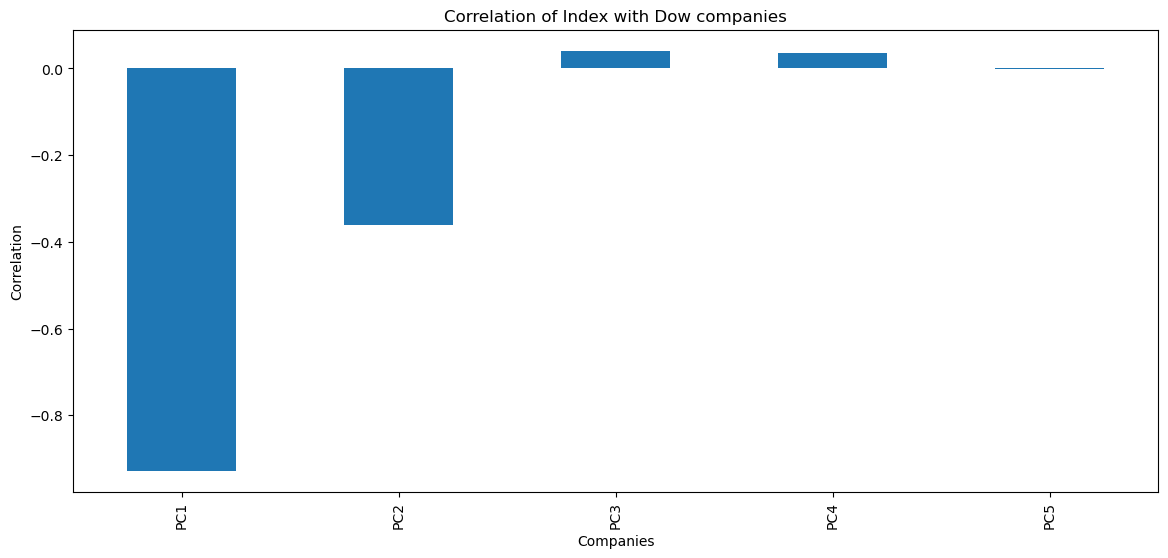

In [24]:
#Selecciono mis features
features = [col for col in df_close_last.columns]
features.remove('Date')
features.remove('Index')
#features = [col for col in df_close_last.columns if col not in ['Date', 'Index']]
print(features)
# Extrigo
feature_data = df_close_last[features].fillna(df_close_last.mean())

# Normalizo
scaler = StandardScaler()
scaled_feature_data = scaler.fit_transform(feature_data)

# Aplico pca
pca = PCA(n_components=5) 
principal_components = pca.fit_transform(scaled_feature_data)

# Creo DF para los componentes principales 
pc_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(principal_components.shape[1])])

df_close_last = pd.concat([df_close_last[['Index']],df_close_last[['Date']], pc_df], axis=1)
df_close_last.head()

# Ratio de Varianza
explained_variance = pca.explained_variance_ratio_
print('Explained variance by component:', explained_variance)

# Correlaciones:

# Matriz de correlacion
correlation_matrix = df_close_last.corr()
print(correlation_matrix)

# Correlacion de las empresas con el Dow Index
# Son demasiadas empresas, por lo tanto las correlaciones se muestran mejor como grafico de histogramas
# Transposicion de la matriz
correlation_matrix = correlation_matrix[['Index']].transpose()

# Todas las correlaciones a partir de la segunda columna
correlations = correlation_matrix.loc['Index', 'PC1':]

# Plot 
plt.figure(figsize=(14, 6))
correlations.plot(kind='bar')
plt.xlabel('Companies')
plt.ylabel('Correlation')
plt.title('Correlation of Index with Dow companies')
plt.xticks(rotation=90, fontsize=10)
plt.show()

# Modelo ARIMA

In [25]:
df_close_last.head(2)

,Index,Date,PC1,PC2,PC3,PC4,PC5
0,25776.61,2019-05-22,5.696852,-0.480091,-4.827448,-0.37601,-0.536219
1,25490.47,2019-05-23,5.842682,-0.135840,-4.381575,-0.35171,-0.461953


In [26]:
dfa = df_close_last.copy()

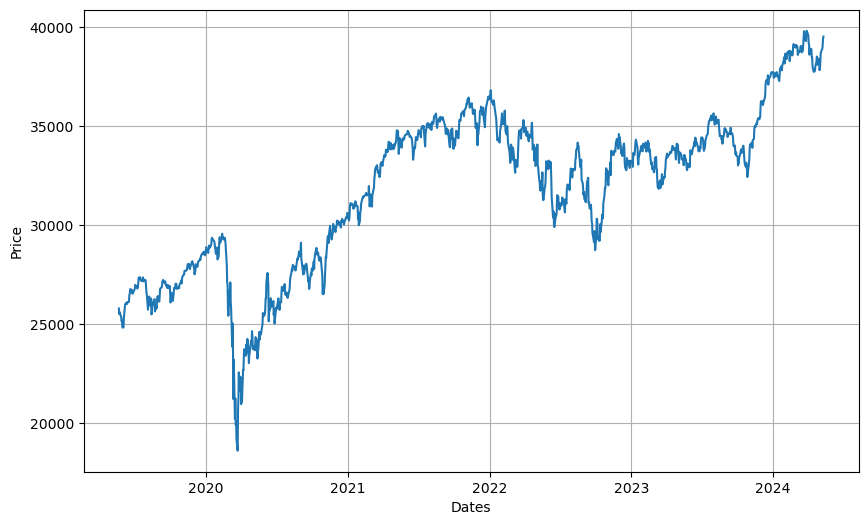

In [27]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Price')
plt.plot(dfa["Date"],dfa['Index'])
plt.show()

In [28]:
dfa_train, dfa_test = train_test_split(dfa, test_size=300, random_state=2024, shuffle=False)

In [29]:
dfa_train.columns

Index(['Index', 'Date', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5'], dtype='object')

In [30]:
#columns = (['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])
columns = (['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])
modela = auto_arima(y = dfa_train['Index'], exogenous = dfa_train[columns], trace = True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=13978.606, Time=2.81 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=14049.921, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=14031.333, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=14034.965, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=14048.282, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=14023.680, Time=0.49 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=14025.014, Time=0.73 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=13978.108, Time=2.53 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=14026.540, Time=1.07 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=13980.036, Time=3.64 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=13979.059, Time=4.37 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=14026.511, Time=1.78 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=13986.069, Time=2.29 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=13981.881, Time=4.09 sec
 ARIMA(3,1,2)(0,0,0

In [31]:
modela.fit(dfa_train['Index'],dfa_train[columns])

ARIMA(order=(3, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [32]:
# Ajustar el modelo con datos de entrenamiento
modela = ARIMA(dfa_train['Index'], exog=dfa_train[columns], order = (3,1,2))
modela_fit = modela.fit()

# Predecir con datos de prueba
forecasta2 = modela_fit.predict(start=len(dfa_train), end=len(dfa_train) + len(dfa_test) - 1, exog=dfa_test[columns])

# Mostrar resultados
print(forecasta2)

/home/gabriel/anaconda3/envs/dhdsblend2021/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/gabriel/anaconda3/envs/dhdsblend2021/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


952     33369.170103
953     33415.519417
954     32862.240250
955     32804.246729
956     32269.770921
            ...     
1247    39116.826579
1248    39258.917144
1249    39448.148752
1250    39680.290866
1251    39842.610565
Name: predicted_mean, Length: 300, dtype: float64


In [39]:
forecasta2.dtype

index = range(952, 952 + len(forecasta2))
series = pd.Series(forecasta2, index=index, name='value')

# Convertir la Serie en un DataFrame
df_forecasta = pd.DataFrame(series)

# Asignar el valor de la columna 'date' del DataFrame 2 al DataFrame 1
df_forecasta['date'] = dfa.loc[960:, "Date"]


print(df_forecasta.tail(10))

             value       date
1242  38913.040619 2024-04-29
1243  38430.110605 2024-04-30
1244  38439.796123 2024-05-01
1245  38601.142162 2024-05-02
1246  38927.282654 2024-05-03
1247  39116.826579 2024-05-06
1248  39258.917144 2024-05-07
1249  39448.148752 2024-05-08
1250  39680.290866 2024-05-09
1251  39842.610565 2024-05-10


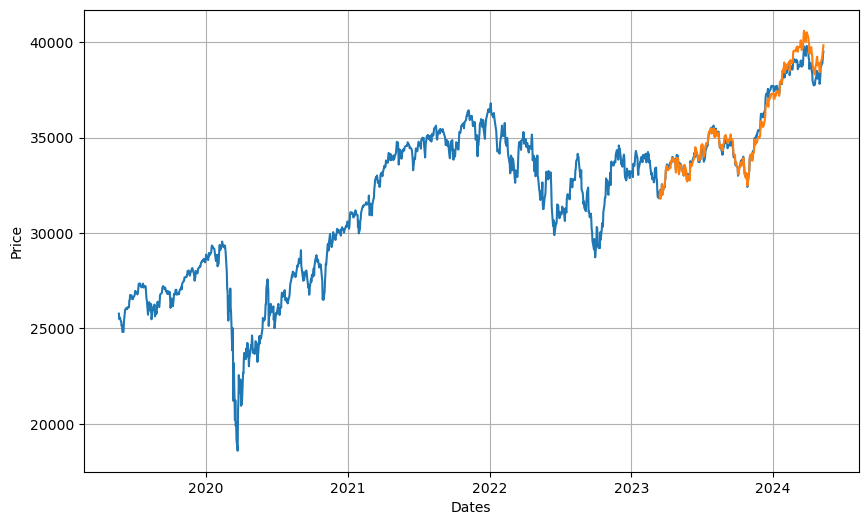

In [40]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Price')
plt.plot(dfa["Date"],dfa['Index'])
plt.plot(df_forecasta["date"],df_forecasta["value"])
plt.show()

In [41]:
RMSE(forecasta2,dfa_test['Index'])

372.80965552054056

In [42]:
dfb = dfa.copy()
columns = (['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])
target_column = 'Index'

# Asegurarse de que 'Date' esté en el índice
dfb['Date'] = pd.to_datetime(dfb['Date'])
dfb.set_index('Date', inplace=True)

# Ajustar el modelo ARIMA con todos los datos disponibles
modela = ARIMA(dfb[target_column], exog=dfb[columns])
modela_fit = modela.fit()

# Crear DataFrame para los próximos 60 días
last_date = dfb.index[-1]
future_dates = pd.date_range(start=last_date, periods=60)

# Generar tendencias para las variables exógenas futuras (esto es solo un ejemplo)
future_exog = pd.DataFrame(index=future_dates)

for col in columns:
    # Preparar los datos para la regresión lineal
    X = np.arange(len(df_close_last)).reshape(-1, 1)
    y = df_close_last[col].values
    
    # Ajustar el modelo de regresión lineal
    model_exog = LinearRegression()
    model_exog.fit(X, y)
    
    # Predecir los próximos 60 días
    X_future = np.arange(len(df_close_last), len(df_close_last) + 60).reshape(-1, 1)
    future_exog[col] = model_exog.predict(X_future)



# Predecir los próximos 60 registros si no hay NaN en future_exog
if not future_exog.isnull().values.any():
    forecasta_future = modela_fit.forecast(steps=60, exog=future_exog)
    # Mostrar resultados
    print(forecasta_future)
else:
    print("Future exogenous variables contain NaN values. Please check the models.")

/home/gabriel/anaconda3/envs/dhdsblend2021/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/gabriel/anaconda3/envs/dhdsblend2021/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/gabriel/anaconda3/envs/dhdsblend2021/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


1252    37469.213800
1253    37478.219651
1254    37487.225503
1255    37496.231354
1256    37505.237205
1257    37514.243057
1258    37523.248908
1259    37532.254760
1260    37541.260611
1261    37550.266462
1262    37559.272314
1263    37568.278165
1264    37577.284017
1265    37586.289868
1266    37595.295719
1267    37604.301571
1268    37613.307422
1269    37622.313273
1270    37631.319125
1271    37640.324976
1272    37649.330828
1273    37658.336679
1274    37667.342530
1275    37676.348382
1276    37685.354233
1277    37694.360085
1278    37703.365936
1279    37712.371787
1280    37721.377639
1281    37730.383490
1282    37739.389341
1283    37748.395193
1284    37757.401044
1285    37766.406896
1286    37775.412747
1287    37784.418598
1288    37793.424450
1289    37802.430301
1290    37811.436152
1291    37820.442004
1292    37829.447855
1293    37838.453707
1294    37847.459558
1295    37856.465409
1296    37865.471261
1297    37874.477112
1298    37883.482964
1299    37892

/home/gabriel/anaconda3/envs/dhdsblend2021/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/gabriel/anaconda3/envs/dhdsblend2021/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [43]:
import holidays
from datetime import timedelta
index = range(1252, 1252 + len(forecasta_future))
series = pd.Series(forecasta_future, index=index, name='value')

df_forecasta_future = pd.DataFrame(series)

start_date = pd.Timestamp('2024-05-23') + timedelta(days=1) 
end_date = start_date + timedelta(days=90)

us_holidays = holidays.US()

def is_business_day(date):
    return date.weekday() < 5 and date not in us_holidays

business_dates = [date for date in pd.date_range(start=start_date, end=end_date) if is_business_day(date)]

df_new = pd.DataFrame({'date': business_dates})
df_new.index += 1252

df_forecasta_future["date"]=df_new["date"] 



print(df_forecasta_future)

             value       date
1252  37469.213800 2024-05-24
1253  37478.219651 2024-05-28
1254  37487.225503 2024-05-29
1255  37496.231354 2024-05-30
1256  37505.237205 2024-05-31
1257  37514.243057 2024-06-03
1258  37523.248908 2024-06-04
1259  37532.254760 2024-06-05
1260  37541.260611 2024-06-06
1261  37550.266462 2024-06-07
1262  37559.272314 2024-06-10
1263  37568.278165 2024-06-11
1264  37577.284017 2024-06-12
1265  37586.289868 2024-06-13
1266  37595.295719 2024-06-14
1267  37604.301571 2024-06-17
1268  37613.307422 2024-06-18
1269  37622.313273 2024-06-20
1270  37631.319125 2024-06-21
1271  37640.324976 2024-06-24
1272  37649.330828 2024-06-25
1273  37658.336679 2024-06-26
1274  37667.342530 2024-06-27
1275  37676.348382 2024-06-28
1276  37685.354233 2024-07-01
1277  37694.360085 2024-07-02
1278  37703.365936 2024-07-03
1279  37712.371787 2024-07-05
1280  37721.377639 2024-07-08
1281  37730.383490 2024-07-09
1282  37739.389341 2024-07-10
1283  37748.395193 2024-07-11
1284  3775

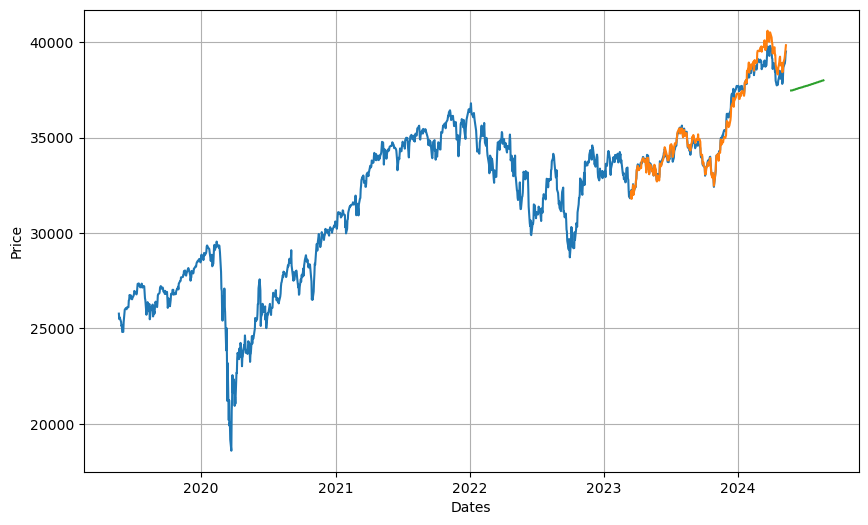

In [44]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Price')
plt.plot(dfa["Date"],dfa['Index'])
plt.plot(df_forecasta["date"],df_forecasta["value"])
plt.plot(df_forecasta_future["date"],df_forecasta_future["value"])
plt.show()